# Hackathon Project
## Heart Rate Regression

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from functools import reduce

from scipy.stats import zscore

from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso

%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
def plot_corr(df, size):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size,size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for (i, j), z in np.ndenumerate(corr):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
        
def calc_precision(tp, fp):
    return tp/(tp+fp)

def calc_recall(tp, fn):
    return tp/(tp+fn)

def calc_f1(tp, fp, fn):
    p = calc_precision(tp, fp)
    r = calc_recall(tp, fn)
    return 2*((p*r)/(p+r))

def missing_check(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    md = pd.concat([total,percent], axis=1, keys=['Total', 'Percent'])
    
    return md

In [3]:
frequency = pd.read_csv('train/frequency_domain_features_train.csv')
hr = pd.read_csv('train/heart_rate_non_linear_features_train.csv')
time = pd.read_csv('train/time_domain_features_train.csv')

In [4]:
data = reduce(lambda l,r: pd.merge(l,r,on='uuid'), [frequency, hr, time])

In [5]:
data.drop('datasetId', axis=1, inplace=True)
data.set_index('uuid', inplace=True, verify_integrity=True)

In [6]:
data.head()

,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,SD1,SD2,sampen,higuci,condition,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR
uuid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
89df2855-56eb-4706-a23b-b39363dd605a,2661.894136,72.203287,1009.249419,27.375666,98.485263,15.522603,0.421047,1.514737,3686.666157,65.018055,0.015380,11.001565,199.061782,2.139754,1.163485,no stress,885.157845,853.763730,140.972741,15.554505,15.553371,9.063146,69.499952,11.133333,0.533333,-0.856554,0.335218,-0.000203,-0.000179,0.017080,0.007969,0.007969,2.143342,-0.856554,0.335218
80c795e4-aa56-4cc0-939c-19634b89cbb2,2314.265450,76.975728,690.113275,22.954139,99.695397,2.108525,0.070133,0.304603,3006.487251,327.296635,0.003055,9.170129,114.634458,2.174499,1.084711,interruption,939.425371,948.357865,81.317742,12.964439,12.964195,6.272369,64.363150,5.600000,0.000000,-0.408190,-0.155286,-0.000059,0.000611,0.013978,0.004769,0.004769,2.930855,-0.408190,-0.155286
c2d5d102-967c-487d-88f2-8b005a449f3e,1373.887112,51.152225,1298.222619,48.335104,98.950472,13.769729,0.512671,1.049528,2685.879461,94.280910,0.010607,11.533417,118.939253,2.135350,1.176315,interruption,898.186047,907.006860,84.497236,16.305279,16.305274,5.182201,67.450066,13.066667,0.200000,0.351789,-0.656813,-0.000011,-0.000263,0.018539,0.008716,0.008716,2.127053,0.351789,-0.656813
37eabc44-1349-4040-8896-0d113ad4811f,2410.357408,70.180308,1005.981659,29.290305,98.224706,18.181913,0.529387,1.775294,3434.520980,55.328701,0.018074,11.119476,127.318597,2.178341,1.179688,no stress,881.757865,893.460030,90.370537,15.720468,15.720068,5.748591,68.809562,11.800000,0.133333,-0.504947,-0.386138,0.000112,0.000494,0.017761,0.008660,0.008660,2.050988,-0.504947,-0.386138
aa777a6a-7aa3-4f6e-aced-70f8691dd2b7,1151.177330,43.918366,1421.782051,54.242160,96.720007,48.215822,1.839473,3.279993,2621.175204,29.487873,0.033912,13.590641,87.718281,2.221121,1.249612,no stress,809.625331,811.184865,62.766242,19.213819,19.213657,3.266724,74.565728,20.200000,0.200000,-0.548408,-0.154252,-0.000100,-0.002736,0.023715,0.013055,0.013055,1.816544,-0.548408,-0.154252


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 369289 entries, 89df2855-56eb-4706-a23b-b39363dd605a to 1f2eb52d-4f09-4921-a383-ef1bc6221789
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   VLF                369289 non-null  float64
 1   VLF_PCT            369289 non-null  float64
 2   LF                 369289 non-null  float64
 3   LF_PCT             369289 non-null  float64
 4   LF_NU              369289 non-null  float64
 5   HF                 369289 non-null  float64
 6   HF_PCT             369289 non-null  float64
 7   HF_NU              369289 non-null  float64
 8   TP                 369289 non-null  float64
 9   LF_HF              369289 non-null  float64
 10  HF_LF              369289 non-null  float64
 11  SD1                369289 non-null  float64
 12  SD2                369289 non-null  float64
 13  sampen             369289 non-null  float64
 14  higuci             369289 non-null  floa

In [8]:
data['HR'].describe()

count    369289.000000
mean         73.941824
std          10.337453
min          48.737243
25%          66.715776
50%          74.217809
75%          80.334937
max         113.752309
Name: HR, dtype: float64

In [9]:
data['condition'].unique()

array(['no stress', 'interruption', 'time pressure'], dtype=object)

In [10]:
condition_struct = {
    'condition': {
        'no stress': 0,
        'interruption': 1,
        'time pressure': 2
    }
}

data = data.replace(condition_struct)

In [11]:
missing_check(data)

,Total,Percent
SKEW_REL_RR,0,0.0
TP,0,0.0
higuci,0,0.0
sampen,0,0.0
SD2,0,0.0
SD1,0,0.0
HF_LF,0,0.0
LF_HF,0,0.0
HF_NU,0,0.0
MEAN_RR,0,0.0


In [12]:
dupes = data.duplicated()
sum(dupes)

0

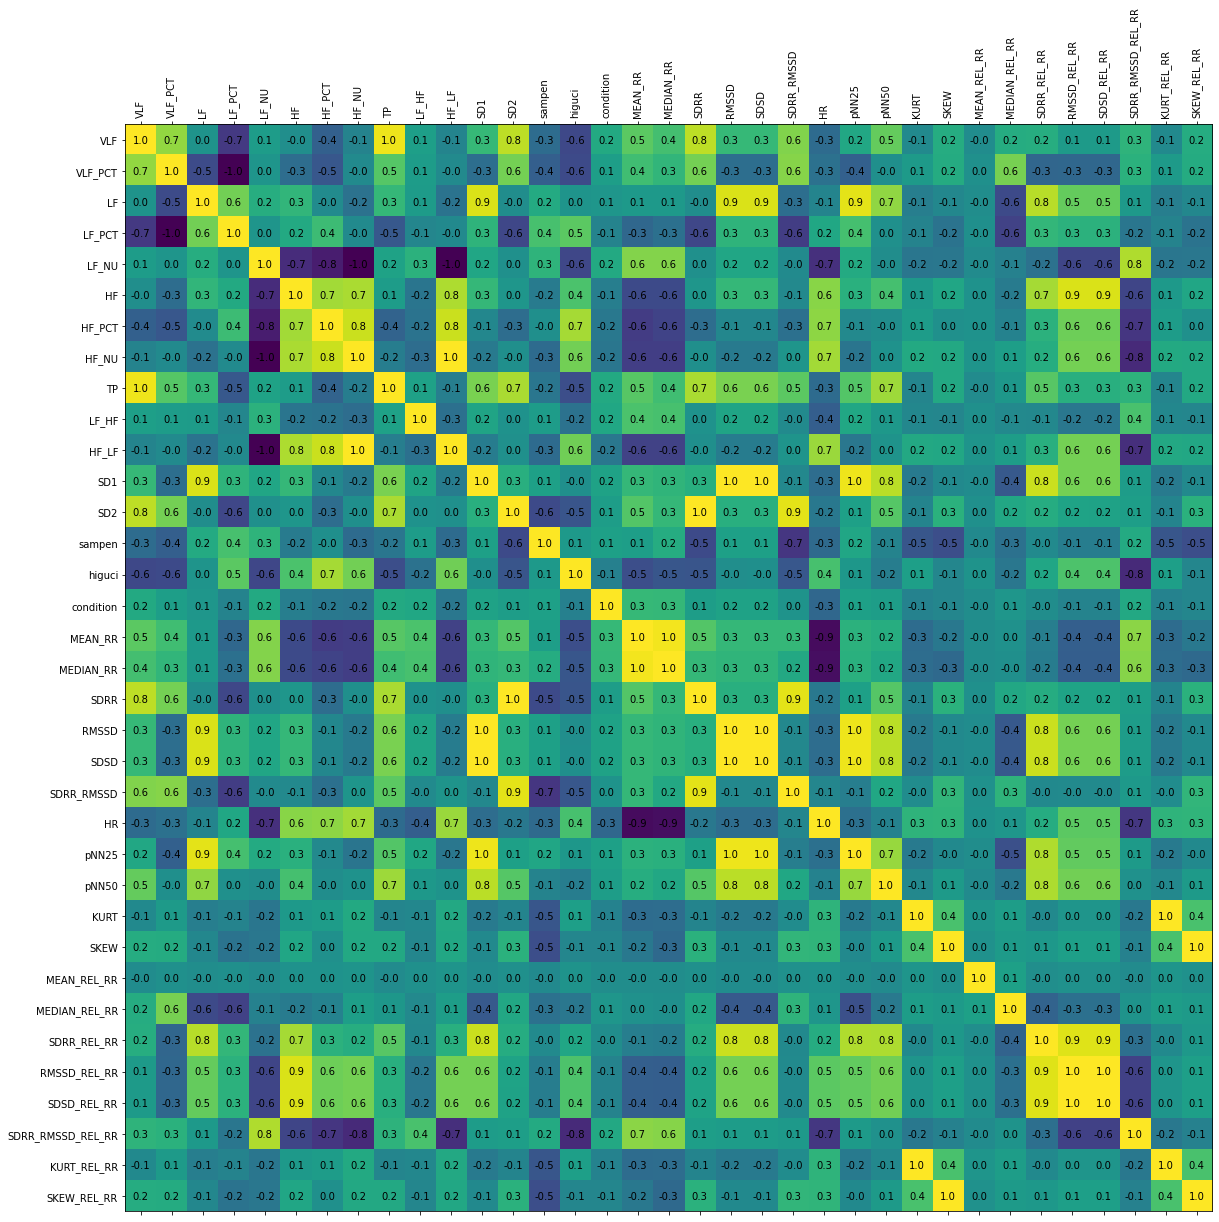

In [13]:
plot_corr(data, 20)

In [14]:
x = data.drop('HR', axis=1)
y = data['HR']

x_train, x_test, y_train, y_test = tts(x, y, test_size=.3, random_state=42)

In [15]:
#dt1 = DecisionTreeRegressor(random_state=42, criterion='mae')
#dt1.fit(x_train, y_train)

#print(dt1.score(x_train, y_train))
#print(dt1.score(x_test, y_test))

In [16]:
#dt2 = Pipeline([
#    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
#    ('reg', DecisionTreeRegressor(random_state=42, criterion='mae'))
#])

#dt2.fit(x_train, y_train)

#print(dt2.score(x_train, y_train))
#print(dt2.score(x_test, y_test))

In [17]:
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

The coefficient for VLF is 611883233.5157442
The coefficient for VLF_PCT is -18480779.621127103
The coefficient for LF is 611883233.5144612
The coefficient for LF_PCT is -18480779.562586643
The coefficient for LF_NU is -38943474.43984302
The coefficient for HF is 611883233.5142504
The coefficient for HF_PCT is -18480779.302736077
The coefficient for HF_NU is -38943475.63801276
The coefficient for TP is -611883233.515451
The coefficient for LF_HF is 0.0017467268413032277
The coefficient for HF_LF is 97.18040314796687
The coefficient for SD1 is 386283.8551691357
The coefficient for SD2 is 0.6944296750918116
The coefficient for sampen is -0.8992529900733887
The coefficient for higuci is -7.477942902570363
The coefficient for condition is 0.0020379651101108467
The coefficient for MEAN_RR is -0.09532622410865056
The coefficient for MEDIAN_RR is 0.015071530800564061
The coefficient for SDRR is -0.9563538124246582
The coefficient for RMSSD is -1.0411077649239917
The coefficient for SDSD is -2

In [18]:
ridge = Ridge(alpha=.3)
ridge.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, ridge.coef_[idx]))

The coefficient for VLF is -0.0010403111455312792
The coefficient for VLF_PCT is -0.1120697850385334
The coefficient for LF is -0.002746994103471945
The coefficient for LF_PCT is -0.06070044167473027
The coefficient for LF_NU is 0.5808173645456967
The coefficient for HF is 0.0050371686595181734
The coefficient for HF_PCT is 0.17277043767485034
The coefficient for HF_NU is -0.5808173823433227
The coefficient for TP is 0.0012606833192344293
The coefficient for LF_HF is 0.0018224833973182735
The coefficient for HF_LF is 94.46479697351685
The coefficient for SD1 is -1.6631148164965548
The coefficient for SD2 is 0.7647854549816485
The coefficient for sampen is -1.039057091927128
The coefficient for higuci is -8.459020024259534
The coefficient for condition is 0.018520552908459647
The coefficient for MEAN_RR is -0.09975873170752655
The coefficient for MEDIAN_RR is 0.01635537501659659
The coefficient for SDRR is -1.0499877095630807
The coefficient for RMSSD is 2.656261801752506
The coefficien

In [19]:
lasso = Lasso(alpha=.2)
lasso.fit(x_train, y_train)

/Users/phil/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46386.778476453386, tolerance: 2752.3434370668
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.2)

In [20]:
ridge.coef_

array([-1.04031115e-03, -1.12069785e-01, -2.74699410e-03, -6.07004417e-02,
        5.80817365e-01,  5.03716866e-03,  1.72770438e-01, -5.80817382e-01,
        1.26068332e-03,  1.82248340e-03,  9.44647970e+01, -1.66311482e+00,
        7.64785455e-01, -1.03905709e+00, -8.45902002e+00,  1.85205529e-02,
       -9.97587317e-02,  1.63553750e-02, -1.04998771e+00,  2.65626180e+00,
       -2.35121486e+00,  6.54752504e-02,  3.18398032e-01,  5.62162621e-01,
        2.09730713e-02,  1.54136884e-01, -3.59265458e+00,  7.42270692e+01,
        8.43504880e+01,  1.07949536e+02,  1.07949100e+02, -3.07914038e-02,
        2.09730712e-02,  1.54136884e-01])

In [21]:
lasso.coef_

array([ 1.84336959e-06, -2.53642191e-02, -9.12146436e-04,  0.00000000e+00,
       -0.00000000e+00,  1.98998585e-02,  0.00000000e+00,  0.00000000e+00,
        1.12816289e-04,  2.21086665e-03,  0.00000000e+00, -0.00000000e+00,
        4.42590393e-03, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -1.02988859e-01,  1.50752121e-02,  3.69952738e-02, -3.04949647e-01,
       -2.67083614e-03,  1.41240437e-02,  1.22341424e-01,  0.00000000e+00,
        4.32195489e-02,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.13386137e-17,  0.00000000e+00])

In [22]:
for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, lasso.coef_[idx]))

The coefficient for VLF is 1.8433695857214968e-06
The coefficient for VLF_PCT is -0.02536421906659815
The coefficient for LF is -0.0009121464357844959
The coefficient for LF_PCT is 0.0
The coefficient for LF_NU is -0.0
The coefficient for HF is 0.019899858455512755
The coefficient for HF_PCT is 0.0
The coefficient for HF_NU is 0.0
The coefficient for TP is 0.0001128162894985291
The coefficient for LF_HF is 0.0022108666493429385
The coefficient for HF_LF is 0.0
The coefficient for SD1 is -0.0
The coefficient for SD2 is 0.004425903929859802
The coefficient for sampen is -0.0
The coefficient for higuci is -0.0
The coefficient for condition is -0.0
The coefficient for MEAN_RR is -0.10298885894751897
The coefficient for MEDIAN_RR is 0.015075212064343698
The coefficient for SDRR is 0.03699527384922989
The coefficient for RMSSD is -0.3049496466009554
The coefficient for SDSD is -0.002670836138614498
The coefficient for SDRR_RMSSD is 0.014124043654320134
The coefficient for pNN25 is 0.12234142

In [23]:
# Drop the columns with 0 coefficient
for idx, col_name in enumerate(x_train.columns):
    if lasso.coef_[idx] == 0.0 or lasso.coef_[idx] == -0.0:
        data.drop(col_name, axis=1, inplace=True)

In [24]:
data.head()

,VLF,VLF_PCT,LF,HF,TP,LF_HF,SD2,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,KURT,KURT_REL_RR
uuid,,,,,,,,,,,,,,,,,
89df2855-56eb-4706-a23b-b39363dd605a,2661.894136,72.203287,1009.249419,15.522603,3686.666157,65.018055,199.061782,885.157845,853.763730,140.972741,15.554505,15.553371,9.063146,69.499952,11.133333,-0.856554,-0.856554
80c795e4-aa56-4cc0-939c-19634b89cbb2,2314.265450,76.975728,690.113275,2.108525,3006.487251,327.296635,114.634458,939.425371,948.357865,81.317742,12.964439,12.964195,6.272369,64.363150,5.600000,-0.408190,-0.408190
c2d5d102-967c-487d-88f2-8b005a449f3e,1373.887112,51.152225,1298.222619,13.769729,2685.879461,94.280910,118.939253,898.186047,907.006860,84.497236,16.305279,16.305274,5.182201,67.450066,13.066667,0.351789,0.351789
37eabc44-1349-4040-8896-0d113ad4811f,2410.357408,70.180308,1005.981659,18.181913,3434.520980,55.328701,127.318597,881.757865,893.460030,90.370537,15.720468,15.720068,5.748591,68.809562,11.800000,-0.504947,-0.504947
aa777a6a-7aa3-4f6e-aced-70f8691dd2b7,1151.177330,43.918366,1421.782051,48.215822,2621.175204,29.487873,87.718281,809.625331,811.184865,62.766242,19.213819,19.213657,3.266724,74.565728,20.200000,-0.548408,-0.548408


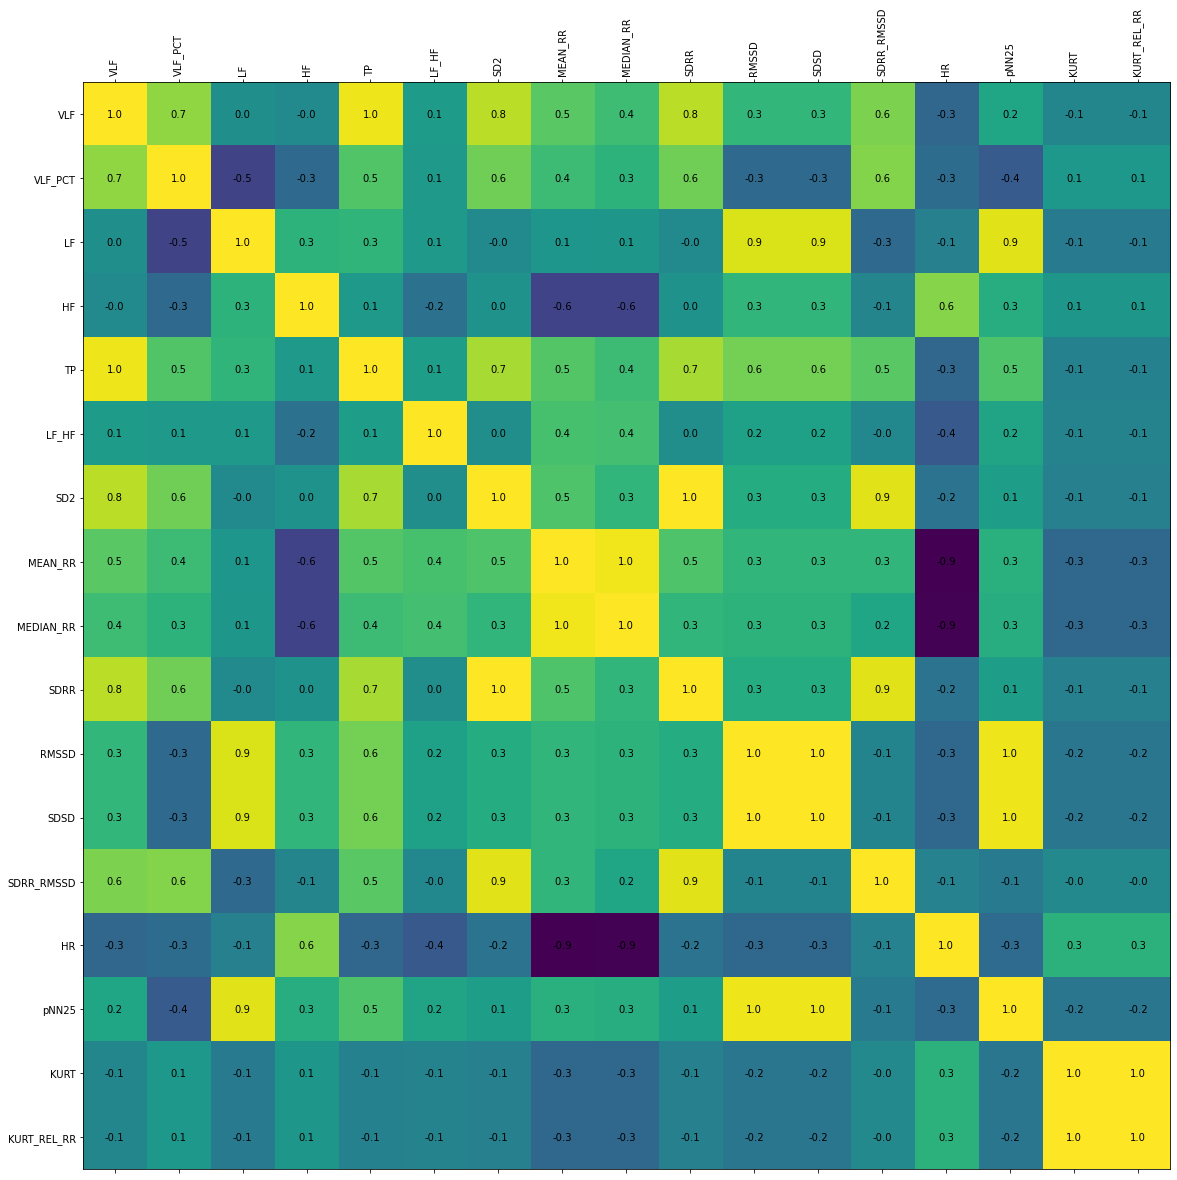

In [25]:
plot_corr(data, 20)

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled = scaler.fit_transform(data)

In [27]:
scaled

array([[0.20086002, 0.67556434, 0.28711572, ..., 0.28257191, 0.01573538,
        0.01573538],
       [0.17295708, 0.7361994 , 0.18743239, ..., 0.14213198, 0.02253053,
        0.02253053],
       [0.0974762 , 0.40810537, 0.37737755, ..., 0.33164129, 0.03404834,
        0.03404834],
       ...,
       [0.14375039, 0.33032912, 0.71420589, ..., 0.7715736 , 0.02220475,
        0.02220475],
       [0.11613049, 0.45472041, 0.37078872, ..., 0.25380711, 0.03781599,
        0.03781599],
       [0.10078362, 0.32406601, 0.5033752 , ..., 0.59390863, 0.02268572,
        0.02268572]])

In [28]:
data_scaled = pd.DataFrame(scaled, index=data.index, columns=data.columns)

data_scaled['HR'] = data['HR']

data_scaled.head()

,VLF,VLF_PCT,LF,HF,TP,LF_HF,SD2,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,KURT,KURT_REL_RR
uuid,,,,,,,,,,,,,,,,,
89df2855-56eb-4706-a23b-b39363dd605a,0.200860,0.675564,0.287116,0.042425,0.254282,0.008044,0.211924,0.435965,0.296233,0.212099,0.475113,0.475064,0.123454,69.499952,0.282572,0.015735,0.015735
80c795e4-aa56-4cc0-939c-19634b89cbb2,0.172957,0.736199,0.187432,0.005616,0.202013,0.041695,0.100622,0.506031,0.379515,0.100855,0.352360,0.352353,0.069644,64.363150,0.142132,0.022531,0.022531
c2d5d102-967c-487d-88f2-8b005a449f3e,0.097476,0.408105,0.377378,0.037615,0.177376,0.011799,0.106298,0.452786,0.343109,0.106784,0.510695,0.510700,0.048624,67.450066,0.331641,0.034048,0.034048
37eabc44-1349-4040-8896-0d113ad4811f,0.180670,0.649862,0.286095,0.049723,0.234906,0.006801,0.117344,0.431575,0.331183,0.117737,0.482979,0.482965,0.059545,68.809562,0.299492,0.021064,0.021064
aa777a6a-7aa3-4f6e-aced-70f8691dd2b7,0.079600,0.316197,0.415972,0.132137,0.172403,0.003486,0.065139,0.338444,0.258746,0.066260,0.648543,0.648539,0.011691,74.565728,0.512690,0.020405,0.020405


In [29]:
dt1 = DecisionTreeRegressor(random_state=1)
dt1.fit(x_train, y_train)

print(dt1.score(x_train, y_train))
print(dt1.score(x_test, y_test))

1.0
0.9999655211493911


In [30]:
x_s = data_scaled.drop('HR', axis=1)
y_s = data_scaled['HR']

x_train_s, x_test_s, y_train_s, y_test_s = tts(x_s, y_s, test_size=.3, random_state=42)

In [31]:
dt2 = DecisionTreeRegressor(random_state=1)
dt2.fit(x_train_s, y_train_s)

print(dt2.score(x_train_s, y_train_s))
print(dt2.score(x_test_s, y_test_s))

1.0
0.9999680553329092


In [32]:
test_f = pd.read_csv('test/frequency_domain_features_test.csv')
test_h = pd.read_csv('test/heart_rate_non_linear_features_test.csv')
test_t = pd.read_csv('test/time_domain_features_test.csv')

test = reduce(lambda l,r: pd.merge(l,r,on='uuid'), [test_f, test_h, test_t])

test.drop('datasetId', axis=1, inplace=True)
test.set_index('uuid', inplace=True, verify_integrity=True)

In [33]:
test = test.replace(condition_struct)
scaled_test = scaler.fit_transform(test)
scaled_test = pd.DataFrame(scaled_test, index=test.index, columns=test.columns)

scaled_test.head()

,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,SD1,SD2,sampen,higuci,condition,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,pNN25,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR
uuid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
62b75db5-bc40-4c8f-9166-daf0efcab4c2,0.139216,0.729361,0.149489,0.281353,0.982636,0.008122,0.009197,0.017364,0.160364,0.024427,0.012337,0.297997,0.102143,0.986113,0.203253,1.0,0.500161,0.371305,0.102287,0.297993,0.297997,0.082960,0.099831,0.024691,0.021479,0.216440,0.519257,0.724682,0.143028,0.057427,0.057427,0.650463,0.021479,0.216440
a99549ad-3eb6-4413-bc90-9053e7f7e684,0.033251,0.089240,0.457026,0.924900,0.915446,0.109840,0.140114,0.084554,0.138629,0.004767,0.061292,0.714175,0.051019,0.973035,0.785473,0.0,0.348242,0.263284,0.052550,0.714174,0.714175,0.000666,0.624365,0.098765,0.032901,0.237069,0.529008,0.257764,0.585787,0.452620,0.452619,0.246121,0.032901,0.237069
cb573d3a-c767-4556-b32e-ad8c08ded214,0.158238,0.720759,0.175926,0.284973,0.926371,0.040115,0.039913,0.073629,0.185956,0.005536,0.053197,0.395517,0.114259,0.898236,0.589402,0.0,0.425362,0.331833,0.114516,0.395513,0.395517,0.072183,0.179357,0.098765,0.029850,0.175855,0.516938,0.653907,0.237279,0.208473,0.208473,0.285686,0.029850,0.175855
47a0c6de-2aef-4ac3-997d-252fa6fd07f1,0.456264,0.908497,0.156453,0.095042,0.960101,0.019485,0.008357,0.039899,0.464555,0.010534,0.028539,0.519133,0.347798,0.914545,0.155510,1.0,0.634477,0.424026,0.347897,0.519243,0.519133,0.199367,0.274112,0.345679,0.019001,0.298355,0.417005,0.609070,0.286189,0.184718,0.184719,0.412301,0.019001,0.298355
de3fd54f-c74e-4fe8-bf2a-7a127f68b312,0.065531,0.649621,0.088282,0.333633,0.720794,0.092585,0.186102,0.279206,0.077307,0.001141,0.214966,0.225344,0.045029,0.907773,0.668760,0.5,0.293322,0.230327,0.045243,0.225343,0.225344,0.045504,0.050761,0.012346,0.064254,0.242369,0.534332,0.679434,0.162830,0.194195,0.194195,0.214000,0.064254,0.242369


In [34]:
scaled_test.shape

(41033, 34)

In [35]:
# Drop the columns with 0 coefficient
for idx, col_name in enumerate(x_train.columns):
    if lasso.coef_[idx] == 0.0 or lasso.coef_[idx] == -0.0:
        scaled_test.drop(col_name, axis=1, inplace=True)

In [36]:
#prediction = pd.DataFrame(dt2.predict(scaled_test), index=scaled_test.index, columns=['HR'])
#prediction.to_csv('prediction01.csv', mode='a', index=True)

In [37]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=1, max_features=16)
rf = rf.fit(x_train_s, y_train_s)

#rf_train = rf.score(x_train_s, y_train_s)
#rf_test = rf.score(x_test_s, y_test_s)

#rf_cv = cross_validate(rf, x_s, y_s, cv=25)

#print(rf_train)
#print(rf_test)
#print(rf_cv['test_score'].mean())
#print(rf_cv['test_score'].std())

In [38]:
#prediction = pd.DataFrame(rf.predict(scaled_test), index=scaled_test.index, columns=['HR'])
#prediction.to_csv('prediction02.csv', mode='a', index=True)

In [39]:
#from xgboost import XGBRegressor

#xgb = XGBRegressor()
#xgb.fit(x_train_s, y_train_s)

#prediction = pd.DataFrame(xgb.predict(scaled_test), index=scaled_test.index, columns=['HR'])
#prediction.to_csv('prediction03.csv', mode='a', index=True)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=2000, num=25)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4],
    'bootstrap':[True,False]
}

rscv = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=1, n_jobs=-1)

rscv.fit(x_train_s, y_train_s)

rscv_best = rscv.best_estimator_

prediction = pd.DataFrame(rscv_best.predict(scaled_test), index=scaled_test.index, columns=['HR'])
prediction.to_csv('prediction04.csv', mode='a', index=True)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
